In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

In [2]:
excel_data_df = pd.ExcelFile(r'../data/sinno.xlsx')
excel_data_df = excel_data_df.parse(excel_data_df.sheet_names[0])

In [3]:
result_df = pd.ExcelFile(r'../data/sinno-result.xlsx')
result_df = result_df.parse(result_df.sheet_names[5])
result_set = result_df.iloc[:, 1].tolist()

In [4]:
# for idx, header in enumerate(excel_data_df.columns.tolist()):
#     print(idx, header)

In [5]:
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Nhân sự")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Đối ngoại")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Chuyên môn")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Hậu cần")]
excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Truyền thông")]
excel_data_df.reset_index(drop=True, inplace=True)
excel_data_df.fillna("", inplace = True)
# filter = [0, 1, 5, 7, 9, 11, 14, 15, 16, 17, 18, 19, 22, 23, 24, 26, 28, 30, 31, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 52, 53, 55, 58, 60, 61, 65, 68, 69, 74, 77, 84, 86, 87, 88, 89, 96, 97, 98, 102, 104, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 120, 127, 129, 134, 135, 137, 138, 139, 140, 140, 142, 145, 146, 149, 152, 154, 155]
# excel_data_df = excel_data_df.iloc[filter]
# excel_data_df.reset_index(drop=True, inplace=True)
# identity = list(excel_data_df.index.values)
identity = excel_data_df.iloc[:, 1].tolist()

In [6]:
import sys; sys.path.insert(0, '..')
from app.loader import Loader
from app.ssmc_fcm import SSMC_FCM, NormMode
loader = Loader()

u:\DATN\algo-clustering-service\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Algo Clustering Config:
 {
    "SERVICE_NAME": "ALGO_CLUSTERING",
    "STOPWORD_PATH": "u:\\DATN\\algo-clustering-service/resources/vn_stopword.txt",
    "FEATURES_PATH": "u:\\DATN\\algo-clustering-service/resources/features.txt",
    "VISION_CONFIG_PATH": "u:\\DATN\\algo-clustering-service/resources/cclub-cloud-vision-api.json",
    "ALGO_PORT": 8002,
    "RESPONSE_CODE_DIR": "u:\\DATN\\algo-clustering-service/resources/response_code.json"
}
No GPU available, using the CPU instead.


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
fields_chosen = {
    # # sample data
    # 2: (loader.feature_engineering, 1),

    # # egg data
    # 3: (loader.multilabel_binarizing, 1),
    # 4: (loader.multilabel_binarizing, 1),
    # 5: (loader.feature_engineering, 1),
    # 6: (loader.feature_engineering, 1),
    # 7: (loader.multilabel_binarizing, 1),
    # 8: (loader.multilabel_binarizing, 1),
    # 9: (loader.multilabel_binarizing, 1),
    # 10: (loader.feature_engineering, 1),

    # # nha data BCM
    # 40: (loader.feature_engineering, 1),
    # 43: (loader.feature_engineering, 1),
    # 46: (loader.feature_engineering, 1),
    # 49: (loader.feature_engineering, 1),
    # 55: (loader.feature_engineering, 1),
    # 58: (loader.feature_engineering, 1),

    # # nha data BCT
    # 41: (loader.feature_engineering, 1),
    # 44: (loader.feature_engineering, 1),
    # 47: (loader.feature_engineering, 1),
    # 50: (loader.feature_engineering, 1),
    # 62: (loader.feature_engineering, 1),
    # 65: (loader.feature_engineering, 1),
    # 68: (loader.feature_engineering, 1),
    # 71: (loader.feature_engineering, 1),

    # # nha data BDN
    # 41: (loader.feature_engineering, 1),
    # 44: (loader.feature_engineering, 1),
    # 47: (loader.feature_engineering, 1),
    # 50: (loader.feature_engineering, 1),
    # 74: (loader.feature_engineering, 1),
    # 77: (loader.feature_engineering, 1),
    # 80: (loader.feature_engineering, 1),

    # # sinno data nhan su
    # 10: (loader.feature_engineering, 1),
    # 18: (loader.feature_engineering, 1),
    # 19: (loader.feature_engineering, 1),
    # 20: (loader.multilabel_binarizing, 1),
    # 21: (loader.feature_engineering, 1),
    # 34: (loader.multilabel_binarizing, 1),
    # 35: (loader.feature_engineering, 1),
    # 36: (loader.feature_engineering, 1),
    # 37: (loader.feature_engineering, 1),
    # 38: (loader.feature_engineering, 1),

    # # sinno data doi ngoai
    # 10: (loader.feature_engineering, 1),
    # 29: (loader.feature_engineering, 1),
    # 30: (loader.feature_engineering, 1),
    # 31: (loader.feature_engineering, 1),
    # 32: (loader.feature_engineering, 1),
    # 34: (loader.multilabel_binarizing, 1),
    # 35: (loader.feature_engineering, 1),
    # 36: (loader.feature_engineering, 1),
    # 37: (loader.feature_engineering, 1),
    # 38: (loader.feature_engineering, 1),

    # # sinno data chuyen mon
    # 10: (loader.feature_engineering, 1),
    # 13: (loader.feature_engineering, 1),
    # 14: (loader.feature_engineering, 1),
    # 15: (loader.feature_engineering, 1),
    # 16: (loader.feature_engineering, 1),
    # 17: (loader.feature_engineering, 1),
    # 34: (loader.multilabel_binarizing, 1),
    # 35: (loader.feature_engineering, 1),
    # 36: (loader.feature_engineering, 1),
    # 37: (loader.feature_engineering, 1),
    # 38: (loader.feature_engineering, 1),

    # # sinno data hau can
    # 10: (loader.feature_engineering, 1),
    # 33: (loader.feature_engineering, 1),
    # 39: (loader.feature_engineering, 1),
    # 40: (loader.feature_engineering, 1),
    # 34: (loader.multilabel_binarizing, 1),
    # 35: (loader.feature_engineering, 1),
    # 36: (loader.feature_engineering, 1),
    # 37: (loader.feature_engineering, 1),
    # 38: (loader.feature_engineering, 1),

    # sinno data truyen thong
    10: (loader.feature_engineering, 1),
    22: (loader.feature_engineering, 1),
    23: (loader.feature_engineering, 1),
    24: (loader.feature_engineering, 1),
    25: (loader.feature_engineering, 1),
    26: (loader.feature_engineering, 1),
    34: (loader.multilabel_binarizing, 1),
    35: (loader.feature_engineering, 1),
    36: (loader.feature_engineering, 1),
    37: (loader.feature_engineering, 1),
    38: (loader.feature_engineering, 1),
}

In [8]:
# from concurrent.futures import ThreadPoolExecutor
# from datetime import datetime

# vectors = {}

# def run_func(id_field, config):
#     start = datetime.now()
#     func = config[0]
#     raw_data = excel_data_df.iloc[:, id_field].tolist()
#     data = func(raw_data)
#     vectors[id_field] = data
#     print(f"{round(100 * (len(list(vectors.keys()))) / len(fields_chosen), 2)}% ({datetime.now() - start})")

# with ThreadPoolExecutor(max_workers=10) as executor:
#     for id_field, config in fields_chosen.items():
#         executor.submit(run_func, id_field, config)


In [9]:
from datetime import datetime
vectors = {}
for id_field, config in fields_chosen.items():
    start = datetime.now()
    func = config[0]
    raw_data = excel_data_df.iloc[:, id_field].tolist()
    data = func(raw_data)
    vectors[id_field] = data
    print(f"{round(100 * (list(fields_chosen).index(id_field) + 1) / len(fields_chosen), 2)}% ({datetime.now() - start})")

9.09% (0:00:00.595070)
18.18% (0:00:01.533398)
27.27% (0:00:01.818100)
36.36% (0:00:01.168531)
45.45% (0:00:01.037101)
54.55% (0:00:01.306019)
63.64% (0:00:00.000987)
72.73% (0:00:00.538051)
81.82% (0:00:00.859105)
90.91% (0:00:00.465904)
100.0% (0:00:00.528806)


In [10]:
cluster_fields = list(fields_chosen.keys())
dataset = None
data_field_len = []
data_field_weight = []
for idx, id_field in enumerate(cluster_fields):
    data = np.array(vectors[id_field])
    dataset = data if idx == 0 else np.hstack((dataset, data))
    data_field_len.append(data.shape[1])
    data_field_weight.append(fields_chosen[id_field][1])
dataset.shape, data_field_len, data_field_weight

((14, 7682),
 [768, 768, 768, 768, 768, 768, 2, 768, 768, 768, 768],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Supervised percentage: 0.0% (0:14)
Cluster members: 
['Nguyễn Thị Sen', 'Trần Thủy Châu', 'Hoàng Đức Nam', 'Khổng Vũ Minh Đức', 'Phan Đức Hưng']
['Trần Văn Lực', 'Lương Đức Trọng', 'Nguyễn Đại An', 'Lê Minh Thái']
['Phạm Sơn Tùng']
[]
['Nguyễn Mạnh Duy', 'Nguyễn Hoàng Đức Trung', 'Trịnh Thuỳ Dung', 'Lương Thái Nam ']


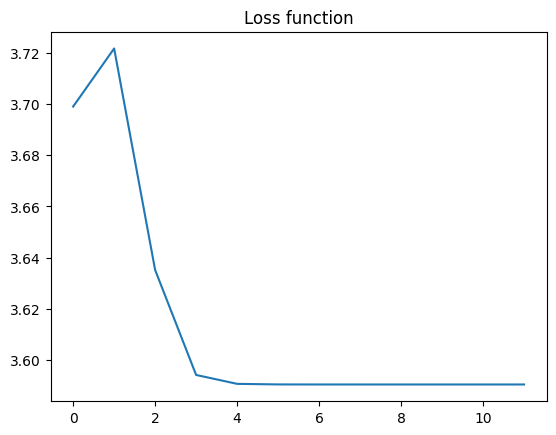

In [15]:
supervised_set = [
    [
        
    ],
]
ssmc_fcm = SSMC_FCM(
    dataset=dataset, 
    fields_len=data_field_len, 
    fields_weight=data_field_weight,
    n_clusters=5, 
    identity=identity,
    supervised_set=supervised_set,
    norm_mode=NormMode.L2.value,
)
ssmc_fcm.clustering()
ssmc_fcm.show_cluster_members()
ssmc_fcm.show_loss_function()

In [12]:
identity_mapping = {iden: idx for idx, iden in enumerate(identity)}
for cluster in ssmc_fcm.pred_labels:
    count = sum([cluster.count(x) for x in result_set])
    print(f"Accuracy: {round(100 * count / len(result_set), 2)}% ({count} in {len(cluster)} of {len(ssmc_fcm.dataset)})")
    # print([identity.index(i) for i in cluster])
    # display(excel_data_df.loc[[identity.index(i) for i in cluster]].iloc[:, [1, *cluster_fields]])

Accuracy: 28.57% (2 in 5 of 14)
Accuracy: 42.86% (3 in 4 of 14)
Accuracy: 14.29% (1 in 1 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 0.0% (0 in 4 of 14)


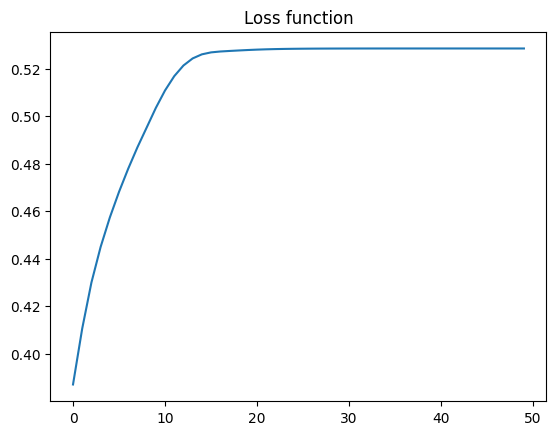

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
Accuracy: 28.57% (2 in 4 of 14)
Accuracy: 28.57% (2 in 5 of 14)
Accuracy: 14.29% (1 in 3 of 14)
Accuracy: 14.29% (1 in 2 of 14)
Accuracy: 0.0% (0 in 0 of 14)



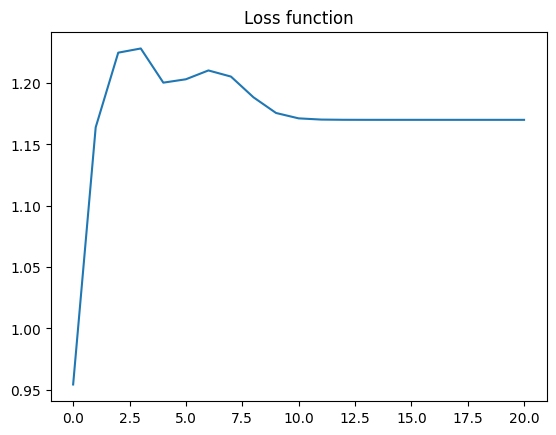

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 14.29% (1 in 1 of 14)
Accuracy: 0.0% (0 in 2 of 14)
Accuracy: 14.29% (1 in 5 of 14)
Accuracy: 57.14% (4 in 6 of 14)



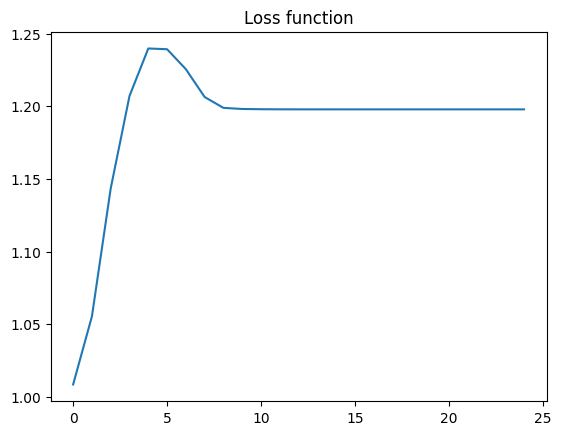

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] 2
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 42.86% (3 in 8 of 14)
Accuracy: 28.57% (2 in 5 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 14.29% (1 in 1 of 14)



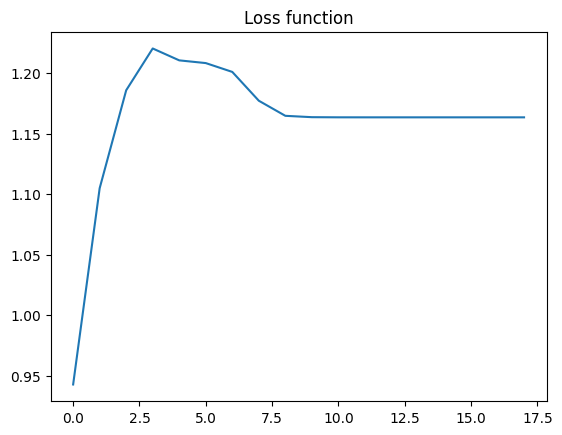

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 3
Accuracy: 0.0% (0 in 1 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 42.86% (3 in 7 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 42.86% (3 in 6 of 14)



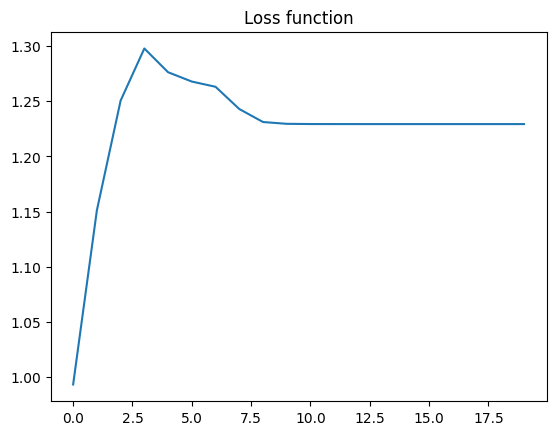

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] 4
Accuracy: 0.0% (0 in 1 of 14)
Accuracy: 28.57% (2 in 5 of 14)
Accuracy: 57.14% (4 in 8 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 0.0% (0 in 0 of 14)



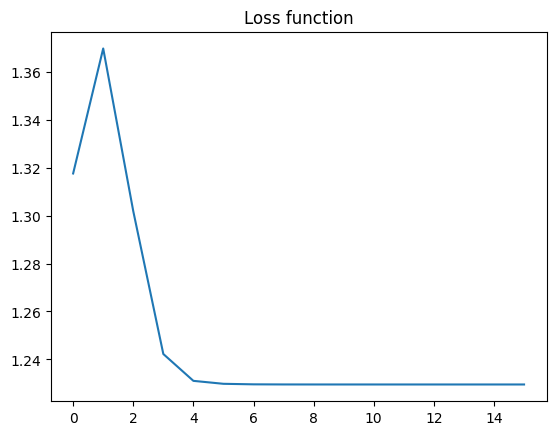

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] 5
Accuracy: 0.0% (0 in 2 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 71.43% (5 in 7 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 14.29% (1 in 5 of 14)



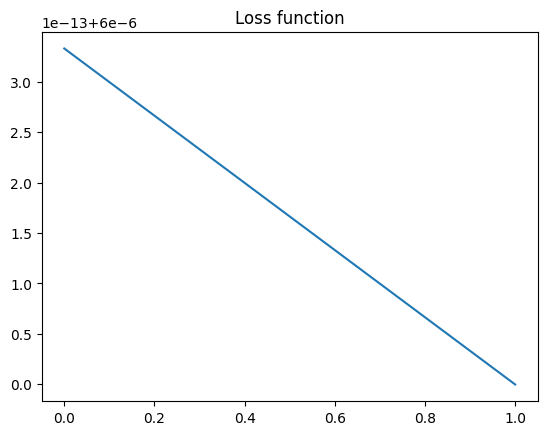

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 6
Accuracy: 57.14% (4 in 8 of 14)
Accuracy: 28.57% (2 in 6 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 0.0% (0 in 0 of 14)



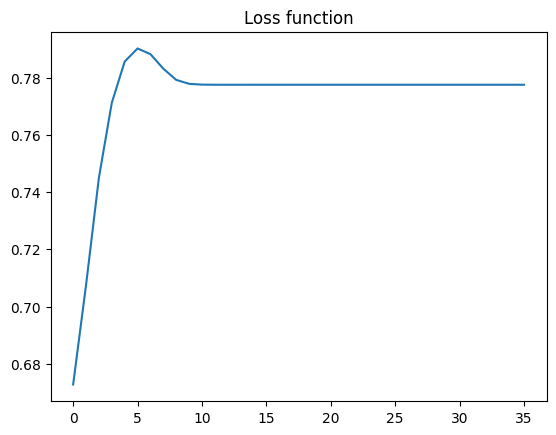

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] 7
Accuracy: 28.57% (2 in 7 of 14)
Accuracy: 42.86% (3 in 4 of 14)
Accuracy: 14.29% (1 in 3 of 14)
Accuracy: 0.0% (0 in 0 of 14)
Accuracy: 0.0% (0 in 0 of 14)



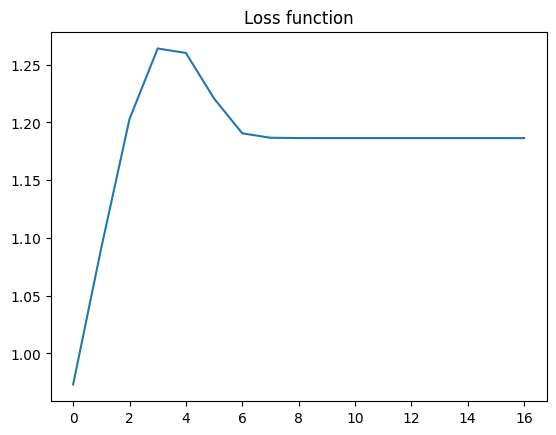

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 8
Accuracy: 28.57% (2 in 5 of 14)
Accuracy: 0.0% (0 in 1 of 14)
Accuracy: 28.57% (2 in 5 of 14)
Accuracy: 28.57% (2 in 3 of 14)
Accuracy: 0.0% (0 in 0 of 14)



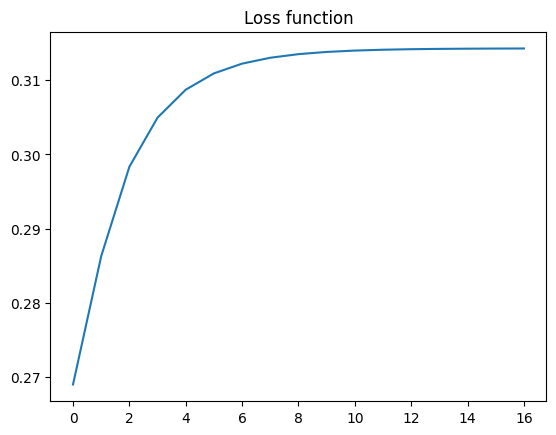

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 9
Accuracy: 42.86% (3 in 9 of 14)
Accuracy: 0.0% (0 in 1 of 14)
Accuracy: 14.29% (1 in 1 of 14)
Accuracy: 14.29% (1 in 1 of 14)
Accuracy: 14.29% (1 in 2 of 14)



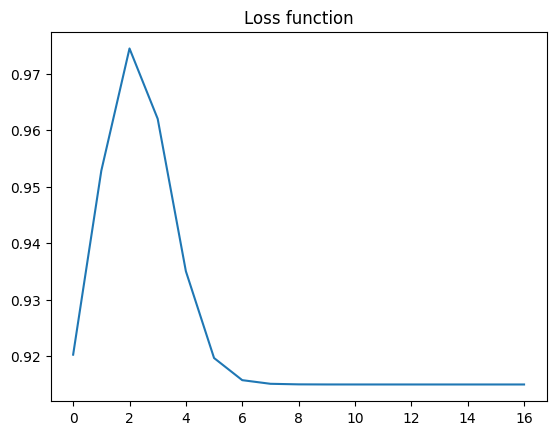

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 10
Accuracy: 28.57% (2 in 6 of 14)
Accuracy: 14.29% (1 in 3 of 14)
Accuracy: 28.57% (2 in 3 of 14)
Accuracy: 0.0% (0 in 1 of 14)
Accuracy: 14.29% (1 in 1 of 14)



In [14]:
identity_mapping = {iden: idx for idx, iden in enumerate(identity)}
for i in range(len(cluster_fields)):
    __weight = [0] * len(cluster_fields)
    __weight[i] = 1
    ssmc_fcm = SSMC_FCM(
        dataset=dataset, 
        fields_len=data_field_len, 
        fields_weight=__weight,
        n_clusters=5, 
        identity=identity,
        supervised_set=supervised_set, 
        norm_mode=NormMode.MINMAX.value,
    )
    ssmc_fcm.clustering()
    ssmc_fcm.show_loss_function()
    print(__weight, i)
    for cluster in ssmc_fcm.pred_labels:
        count = sum([cluster.count(x) for x in result_set])
        print(f"Accuracy: {round(100 * count / len(result_set), 2)}% ({count} in {len(cluster)} of {len(ssmc_fcm.dataset)})")
        # display(excel_data_df.loc[[identity.index(i) for i in cluster]].iloc[:, [1, cluster_fields[i]]])
    print()